In [30]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from jax import vmap
from scipy.stats import beta

import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
#DATA VARIABLES
SYSTEMS_NUM = 120
TIMESTEPS_NUM = 9600
TRAIN_FRAC = 200  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 30

#OPTIMISATION VARIABLES
LR_ADAM = 0.01
LR_NEWTON = 0.5
ITERS = 5

#GP Variables
VAR_Y = 0.1
LEN_SPACE = 0.5
LEN_ALTITUDE = 0.3

#PERIODIC KERNEL
VAR_PERIOD = 1.5
VAR_MATERN = 1
LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100) #48
LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100)#24


#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = False
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 271 - 120

In [29]:
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
#I AM SHUFFLING HERE
data_multiple = data.sample(frac=1, axis=1).iloc[:,:SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000


In [4]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

from suncalc import get_position, get_times
date_solar = stacked.datetime.values
lon_solar = stacked.longitude.values
lat_solar = stacked.latitude.values

solar_positions = get_position(date_solar, lon_solar, lat_solar)
solar_altitude = solar_positions['altitude']

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
t = t / (TIMESTEPS_NUM / 100)

# solar_altitudes = solar_altitude.reshape(R.shape[1], R.shape[0], 1).swapaxes(0,1)

# R = np.append(R, solar_altitudes, axis=2)

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

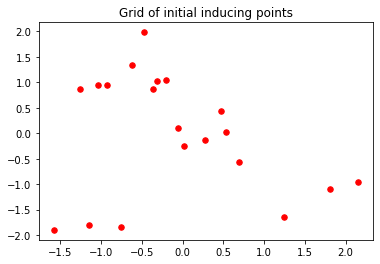

In [5]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = date_solar)

z = R_scaled[2, ::5]

# #CHANGE THE INDUCING POINTS FOR THE SOLAR ALTITUDE TO BE EQUALLY SPACED ALONG THE TOTAL INTERVAL
# z[:,2] = np.linspace(solar_altitude.min(),solar_altitude.max(),  len(z))
    
plt.scatter(*zip(*z[:, :2]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')


# CREATE A TEMPORAL ONLY MODEL

In [6]:
kern_time_period = bayesnewton.kernels.QuasiPeriodicMatern32(variance= VAR_PERIOD,
                                                                  lengthscale_periodic= LEN_PERIOD,
                                                                  period=96/ (TIMESTEPS_NUM / 100),
                                                                  lengthscale_matern= LEN_MATERN,
                                                                  order=2)

kern_time_matern = bayesnewton.kernels.Matern32(variance= VAR_MATERN, lengthscale=LEN_MATERN)


kern_time_day = bayesnewton.kernels.Sum([kern_time_period, kern_time_matern])

### Run for a single system

In [ ]:
system_idx = 0

lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
model = bayesnewton.models.MarkovVariationalGP(kernel = kern_time_day, likelihood = lik, X=t_train, Y=Y_train[:, system_idx,: ])

opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(model.vars())
def train_op(batch_ind = None):
    model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(LR_ADAM, dE)
    return E

if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)

t0 = time.time()
for i in range(1, 20 + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        loss = train_op(mini_batches_indices[mini_batch])
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS

In [ ]:
#GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)
len_samples = len(t_test) + 800
test_mask_shortened = test_mask[-len_samples:]

f_mean, f_var = model.predict(X=t[-len_samples:])

#GET THE Y PREDICTIONS FROM THE F VALUES
f_mean = f_mean.reshape(f_mean.shape[0], -1, 1)
f_var = f_var.reshape(f_var.shape[0], -1, 1)

mean_y, var_y = vmap(model.likelihood.predict, (0, 0, None))(f_mean, f_var, None)
posterior_mean_ts, posterior_var_ts = np.squeeze(mean_y), np.squeeze(var_y)


In [ ]:
#adjust this for the correct quantities
mae = np.nanmean(abs(np.squeeze(Y[-len_samples:, system_idx]) - np.squeeze(posterior_mean_ts)))
print(f'The MAE is {mae.round(3)}')

mae_train = np.nanmean(abs(np.squeeze(Y[-len_samples:, system_idx][~test_mask_shortened]) - np.squeeze(posterior_mean_ts[~test_mask_shortened])))
print(f'The train MAE is {mae_train.round(3)}')

mae_test = np.nanmean(abs(np.squeeze(Y[-len_samples:, system_idx][test_mask_shortened]) - np.squeeze(posterior_mean_ts[test_mask_shortened])))
print(f'The test MAE is {mae_test.round(3)}')

In [ ]:
#Sample values of f at each point
sampled_f = np.random.normal(f_mean[:,:,0], f_var[:,:,0], size=(100, f_var.shape[0], f_var.shape[1]))

alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
beta_sampled = model.likelihood.scale - alpha_sampled

beta_samples = np.random.beta(alpha_sampled, beta_sampled, size=(alpha_sampled.shape[0], alpha_sampled.shape[1], alpha_sampled.shape[2]))
lower_bounds_beta_MC = np.quantile(beta_samples, 0.025, axis=0)
upper_bounds_beta_MC = np.quantile(beta_samples, 0.975, axis=0)

In [ ]:
days_index = max(96, int(((len_samples / 3) // 96) * 96)) #number of time intervals to match 5 beginnings of days
i = system_idx
plt.figure(figsize=(10,7))
plt.title(f'Prediction for system {i}')
plt.plot(np.arange(len(Y))[-len_samples:], Y[:,i][-len_samples:], "xk")
plt.plot(np.arange(len(Y))[-len_samples:], posterior_mean_ts[:][-len_samples:], c="C0", lw=2, zorder=2)
plt.vlines(t_train.shape[0], 0, 1, colors='k')

plt.fill_between(
    np.arange(len(Y))[-len_samples:],
    lower_bounds_beta_MC[:,i],
    upper_bounds_beta_MC[:,i],
    color="C1",
    alpha=0.2)

plt.xticks(ticks = np.arange(len(Y))[-len_samples:-1:days_index], labels = data_multiple.datetime[-len_samples:-1:days_index].values, size=8);


### Now training in loop and store the results!

In [22]:
import copy

In [32]:
model_vars = dict.fromkeys(range(SYSTEMS_NUM))

for system_idx in range(SYSTEMS_NUM):
    
    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.MarkovVariationalGP(kernel = kern_time_day, likelihood = lik, X=t_train, Y=Y_train[:, system_idx,: ])
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
        return E
    train_op = objax.Jit(train_op)

    t0 = time.time()
    for i in range(1, 6 + 1):    
        loss = train_op()
        print('iter %2d, energy: %1.4f' % (i, loss[0]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    data_var = [model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_periodic'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_variance'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_period'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_matern'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_lengthscale'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_variance'].item(),
    model.vars()['(MarkovVariationalGP).likelihood(Beta).transformed_scale'].item()]
    data_model_vars = copy.copy(data_var)
        
    model_vars[system_idx] = data_model_vars
    
    

iter  1, energy: 12435.4120
iter  2, energy: 756.6186
iter  3, energy: -6246.9729
iter  4, energy: -11586.3977
iter  5, energy: -11924.5137
iter  6, energy: -10807.5836
optimisation time: 32.04 secs
iter  1, energy: 15979.4490
iter  2, energy: 2954.1890
iter  3, energy: -4986.2578
iter  4, energy: -9133.0251
iter  5, energy: -12874.7356
iter  6, energy: -13085.3226
optimisation time: 26.21 secs
iter  1, energy: 13837.3763
iter  2, energy: 1719.3637
iter  3, energy: -7199.7292
iter  4, energy: -11102.2310
iter  5, energy: -15248.4164
iter  6, energy: -16664.6515
optimisation time: 26.89 secs
iter  1, energy: 15010.1746
iter  2, energy: 2173.5088
iter  3, energy: -5774.1724
iter  4, energy: -11744.4604
iter  5, energy: -13453.3532
iter  6, energy: -14432.6582
optimisation time: 28.62 secs
iter  1, energy: 22638.2224
iter  2, energy: 9599.4453
iter  3, energy: -1957.7820
iter  4, energy: -8339.9166
iter  5, energy: -10358.1800
iter  6, energy: -11110.8943
optimisation time: 27.06 secs
ite

iter  6, energy: 9955.7550
optimisation time: 36.32 secs
iter  1, energy: 36032.4489
iter  2, energy: 41087.0860
iter  3, energy: 31675.2375
iter  4, energy: 22700.9002
iter  5, energy: 15248.1596
iter  6, energy: 10036.3970
optimisation time: 55.10 secs
iter  1, energy: 33917.2598
iter  2, energy: 40843.0043
iter  3, energy: 31981.1593
iter  4, energy: 23402.3203
iter  5, energy: 17200.2877
iter  6, energy: 11717.4385
optimisation time: 28.44 secs
iter  1, energy: 33779.7125
iter  2, energy: 36720.1116
iter  3, energy: 26220.5849
iter  4, energy: 16992.0038
iter  5, energy: 9349.6195
iter  6, energy: 4910.7495
optimisation time: 16.60 secs
iter  1, energy: 29635.2317
iter  2, energy: 33332.3060
iter  3, energy: 24631.0583
iter  4, energy: 17996.5617
iter  5, energy: 11733.5303
iter  6, energy: 8769.4467
optimisation time: 16.21 secs
iter  1, energy: 37241.3489
iter  2, energy: 45448.8279
iter  3, energy: 35332.2625
iter  4, energy: 26419.3560
iter  5, energy: 19666.2843
iter  6, energ

iter  2, energy: 47421.1840
iter  3, energy: 38237.5180
iter  4, energy: 29904.4792
iter  5, energy: 22690.5444
iter  6, energy: 16975.9539
optimisation time: 16.05 secs
iter  1, energy: 43308.3137
iter  2, energy: 53198.1524
iter  3, energy: 40667.5524
iter  4, energy: 30922.6430
iter  5, energy: 22482.5878
iter  6, energy: 16608.9178
optimisation time: 15.60 secs
iter  1, energy: 37951.1857
iter  2, energy: 41646.4376
iter  3, energy: 34750.1122
iter  4, energy: 27918.9283
iter  5, energy: 20776.8671
iter  6, energy: 16317.5934
optimisation time: 15.99 secs
iter  1, energy: 49315.8413
iter  2, energy: 64573.1897
iter  3, energy: 49460.8508
iter  4, energy: 38695.8571
iter  5, energy: 29140.0899
iter  6, energy: 23025.7349
optimisation time: 16.22 secs
iter  1, energy: 42652.5760
iter  2, energy: 47770.3306
iter  3, energy: 35846.1868
iter  4, energy: 30104.7751
iter  5, energy: 21459.3954
iter  6, energy: 14671.6393
optimisation time: 17.62 secs
iter  1, energy: 51799.1225
iter  2, e

In [36]:
df_variables = pd.DataFrame(model_vars).T
df_variables.columns = ['(QuasiPeriodicMatern32).transformed_lengthscale_periodic',
                        '(QuasiPeriodicMatern32).transformed_variance',
                        '(QuasiPeriodicMatern32).transformed_period',
                        '(QuasiPeriodicMatern32).transformed_lengthscale_matern',
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']




<AxesSubplot:>

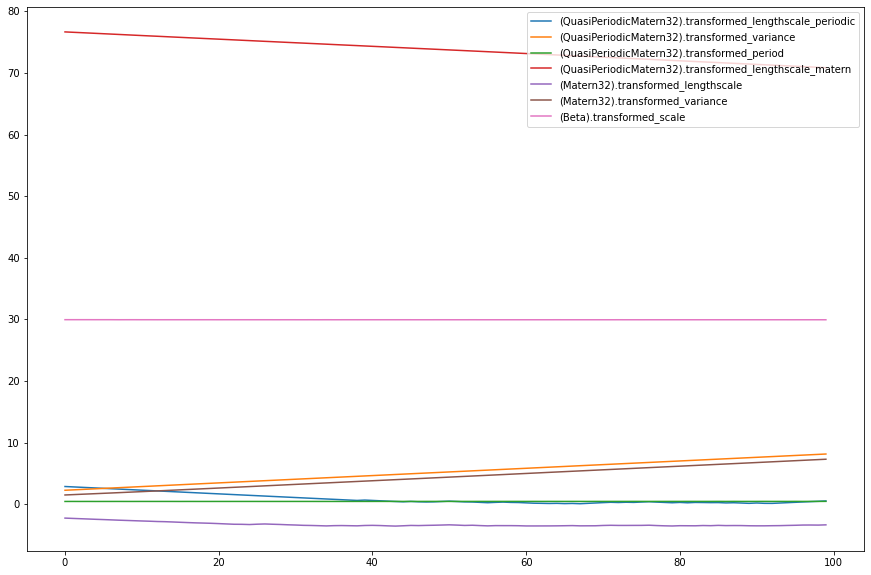

In [40]:
df_variables.plot(figsize=(15,10))


In [41]:
variables_means = df_variables.mean()
variables_means

(QuasiPeriodicMatern32).transformed_lengthscale_periodic     0.855519
(QuasiPeriodicMatern32).transformed_variance                 5.201943
(QuasiPeriodicMatern32).transformed_period                   0.443782
(QuasiPeriodicMatern32).transformed_lengthscale_matern      73.780030
(Matern32).transformed_lengthscale                          -3.298604
(Matern32).transformed_variance                              4.366775
(Beta).transformed_scale                                    29.943636
dtype: float64

In [42]:
variables_vars = df_variables.var()
variables_vars

(QuasiPeriodicMatern32).transformed_lengthscale_periodic    0.683596
(QuasiPeriodicMatern32).transformed_variance                2.967928
(QuasiPeriodicMatern32).transformed_period                  0.000010
(QuasiPeriodicMatern32).transformed_lengthscale_matern      2.887497
(Matern32).transformed_lengthscale                          0.109263
(Matern32).transformed_variance                             2.926938
(Beta).transformed_scale                                    0.000008
dtype: float64

In [43]:
del model

### FOR A SINGLE SYSTEM

In [45]:
system_idx = 0
model_vars_iter = dict.fromkeys(range(200))

lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
model = bayesnewton.models.MarkovVariationalGP(kernel = kern_time_day, likelihood = lik, X=t_train, Y=Y_train[:, system_idx,: ])

opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(model.vars())
def train_op(batch_ind = None):
    model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(LR_ADAM, dE)
    return E

t0 = time.time()
for i in range(1, 200 + 1):
    loss = train_op()

    data_var = [model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_periodic'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_variance'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_period'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel0(QuasiPeriodicMatern32).transformed_lengthscale_matern'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_lengthscale'].item(),
    model.vars()['(MarkovVariationalGP).kernel(Sum).kernel1(Matern32).transformed_variance'].item(),
    model.vars()['(MarkovVariationalGP).likelihood(Beta).transformed_scale'].item()]
    data_model_vars = copy.copy(data_var)
    model_vars_iter[i] = data_model_vars
    
    print('iter %2d, energy: %1.4f' % (i, loss[0]))
    
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS

iter  1, energy: 33333.4677
iter  2, energy: 39614.8997
iter  3, energy: 30893.3970
iter  4, energy: 24917.4762
iter  5, energy: 20750.6834
iter  6, energy: 17197.7340
iter  7, energy: 12171.1504
iter  8, energy: 7901.9270
iter  9, energy: 5973.6056
iter 10, energy: 2670.2024
iter 11, energy: -257.7654
iter 12, energy: -2130.3487
iter 13, energy: -4213.8827
iter 14, energy: -5921.9904
iter 15, energy: -7452.5083
iter 16, energy: -8380.2648
iter 17, energy: -9486.8653
iter 18, energy: -10309.6969
iter 19, energy: -11201.8454
iter 20, energy: -11797.7141
iter 21, energy: -12258.5815
iter 22, energy: -12833.1471
iter 23, energy: -13311.0599
iter 24, energy: -13662.9229
iter 25, energy: -14047.9797
iter 26, energy: -14456.1350
iter 27, energy: -14801.9236
iter 28, energy: -15160.7175
iter 29, energy: -15419.7087
iter 30, energy: -15651.6961
iter 31, energy: -15872.5335
iter 32, energy: -16061.1799
iter 33, energy: -16255.4980
iter 34, energy: -16478.1826
iter 35, energy: -16676.2409
iter 3

,(QuasiPeriodicMatern32).transformed_lengthscale_periodic,(QuasiPeriodicMatern32).transformed_variance,(QuasiPeriodicMatern32).transformed_period,(QuasiPeriodicMatern32).transformed_lengthscale_matern,(Matern32).transformed_lengthscale,(Matern32).transformed_variance,(Beta).transformed_scale
0,None,None,None,None,None,None,None
1,0.499595,8.16053,0.433456,70.853126,-3.379734,7.314693,29.99
2,0.489907,8.170468,0.438678,70.843469,-3.387997,7.32463,29.980084
3,0.480504,8.180275,0.444904,70.834088,-3.396447,7.334515,29.970202
4,0.470992,8.19011,0.447231,70.824619,-3.405025,7.344297,29.96047
...,...,...,...,...,...,...,...
196,1.146608,8.25614,0.443395,70.77483,-1.826142,6.022737,30.700338
197,1.153418,8.254046,0.443401,70.776673,-1.820541,6.016783,30.706798
198,1.160229,8.251949,0.443406,70.778518,-1.814968,6.01085,30.713266
199,1.167041,8.249848,0.443411,70.780364,-1.809423,6.004937,30.719742


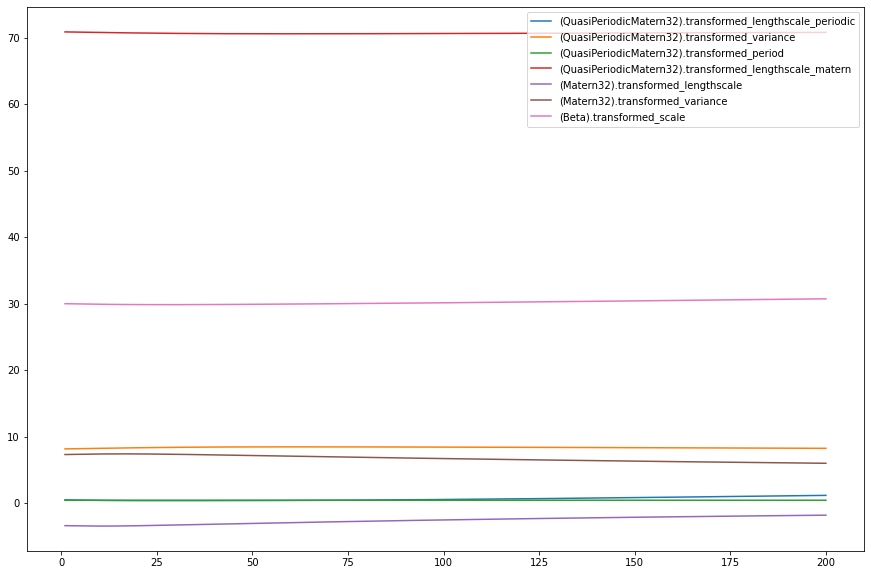

In [48]:
df_variables_iter = pd.DataFrame(model_vars_iter).T
df_variables_iter.columns = ['(QuasiPeriodicMatern32).transformed_lengthscale_periodic',
                        '(QuasiPeriodicMatern32).transformed_variance',
                        '(QuasiPeriodicMatern32).transformed_period',
                        '(QuasiPeriodicMatern32).transformed_lengthscale_matern',
                        '(Matern32).transformed_lengthscale',
                        '(Matern32).transformed_variance',
                        '(Beta).transformed_scale']

df_variables_iter.plot(figsize=(15,10))

df_variables_iter

## SPATIAL ONLY

In [49]:
kern_space0 = bayesnewton.kernels.Matern32(variance=VAR_PERIOD , lengthscale=LEN_SPACE)
kern_space1 = bayesnewton.kernels.Matern32(variance=VAR_PERIOD , lengthscale=LEN_SPACE)
kern_space = bayesnewton.kernels.Separable([kern_space0, kern_space1])

In [55]:
space_model_vars = dict.fromkeys(range(len(t_train)))

for t_idx in range(len(t_train))[:100]: 

    lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    model = bayesnewton.models.VariationalGP(kernel = kern_space, likelihood = lik, X=R_train_scaled[t_idx], Y=Y_train[t_idx])

    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())

    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
        return E
    train_op = objax.Jit(train_op)


    t0 = time.time()
    for i in range(1, 200 + 1):
        loss = train_op()
        print('iter %2d, energy: %1.4f' % (i, loss[0]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    data_var = [model.vars()['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale'].item(),
    model.vars()['(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance'].item(),
    model.vars()['(VariationalGP).likelihood(Beta).transformed_scale'].item()]
    data_model_vars = copy.copy(data_var)
    

    space_model_vars[t_idx] = data_model_vars

iter  1, energy: -948.8307
iter  2, energy: -956.2418
iter  3, energy: -961.1030
iter  4, energy: -963.9655
iter  5, energy: -965.8848
iter  6, energy: -967.6368
iter  7, energy: -969.7150
iter  8, energy: -972.4535
iter  9, energy: -975.9678
iter 10, energy: -979.9926
iter 11, energy: -984.0376
iter 12, energy: -987.6766
iter 13, energy: -990.7143
iter 14, energy: -993.1504
iter 15, energy: -995.1810
iter 16, energy: -997.5855
iter 17, energy: -1000.0390
iter 18, energy: -997.7422
iter 19, energy: -1001.3462
iter 20, energy: -980.5573
iter 21, energy: -1023.2821
iter 22, energy: -1038.0824
iter 23, energy: -1041.6234
iter 24, energy: -1042.2759
iter 25, energy: -1042.4651
iter 26, energy: -1042.5296
iter 27, energy: -1042.5542
iter 28, energy: -1042.5651
iter 29, energy: -1042.5712
iter 30, energy: -1042.5755
iter 31, energy: -1042.5792
iter 32, energy: -1042.5829
iter 33, energy: -1042.5866
iter 34, energy: -1042.5904
iter 35, energy: -1042.5943
iter 36, energy: -1042.5984
iter 37, e

iter 144, energy: -1043.4460
iter 145, energy: -1043.4494
iter 146, energy: -1043.4529
iter 147, energy: -1043.4563
iter 148, energy: -1043.4597
iter 149, energy: -1043.4631
iter 150, energy: -1043.4665
iter 151, energy: -1043.4699
iter 152, energy: -1043.4733
iter 153, energy: -1043.4767
iter 154, energy: -1043.4801
iter 155, energy: -1043.4834
iter 156, energy: -1043.4868
iter 157, energy: -1043.4902
iter 158, energy: -1043.4935
iter 159, energy: -1043.4969
iter 160, energy: -1043.5003
iter 161, energy: -1043.5036
iter 162, energy: -1043.5070
iter 163, energy: -1043.5103
iter 164, energy: -1043.5137
iter 165, energy: -1043.5170
iter 166, energy: -1043.5203
iter 167, energy: -1043.5236
iter 168, energy: -1043.5270
iter 169, energy: -1043.5303
iter 170, energy: -1043.5336
iter 171, energy: -1043.5369
iter 172, energy: -1043.5402
iter 173, energy: -1043.5435
iter 174, energy: -1043.5468
iter 175, energy: -1043.5501
iter 176, energy: -1043.5534
iter 177, energy: -1043.5566
iter 178, ener

iter 90, energy: -1028.0876
iter 91, energy: -1028.0910
iter 92, energy: -1028.0944
iter 93, energy: -1028.0978
iter 94, energy: -1028.1013
iter 95, energy: -1028.1047
iter 96, energy: -1028.1081
iter 97, energy: -1028.1116
iter 98, energy: -1028.1150
iter 99, energy: -1028.1184
iter 100, energy: -1028.1219
iter 101, energy: -1028.1253
iter 102, energy: -1028.1288
iter 103, energy: -1028.1323
iter 104, energy: -1028.1357
iter 105, energy: -1028.1392
iter 106, energy: -1028.1427
iter 107, energy: -1028.1461
iter 108, energy: -1028.1496
iter 109, energy: -1028.1531
iter 110, energy: -1028.1566
iter 111, energy: -1028.1600
iter 112, energy: -1028.1635
iter 113, energy: -1028.1670
iter 114, energy: -1028.1705
iter 115, energy: -1028.1740
iter 116, energy: -1028.1775
iter 117, energy: -1028.1810
iter 118, energy: -1028.1845
iter 119, energy: -1028.1880
iter 120, energy: -1028.1915
iter 121, energy: -1028.1950
iter 122, energy: -1028.1985
iter 123, energy: -1028.2020
iter 124, energy: -1028.

iter 184, energy: -1004.5270
iter 185, energy: -1004.5295
iter 186, energy: -1004.5320
iter 187, energy: -1004.5344
iter 188, energy: -1004.5369
iter 189, energy: -1004.5394
iter 190, energy: -1004.5419
iter 191, energy: -1004.5444
iter 192, energy: -1004.5468
iter 193, energy: -1004.5493
iter 194, energy: -1004.5518
iter 195, energy: -1004.5543
iter 196, energy: -1004.5568
iter 197, energy: -1004.5593
iter 198, energy: -1004.5618
iter 199, energy: -1004.5643
iter 200, energy: -1004.5668
optimisation time: 2.45 secs
iter  1, energy: -819.4775
iter  2, energy: -868.4447
iter  3, energy: -891.5091
iter  4, energy: -903.4585
iter  5, energy: -910.5860
iter  6, energy: -914.9399
iter  7, energy: -917.6596
iter  8, energy: -919.7621
iter  9, energy: -921.8942
iter 10, energy: -924.2313
iter 11, energy: -926.6471
iter 12, energy: -928.9242
iter 13, energy: -930.9366
iter 14, energy: -932.6464
iter 15, energy: -934.0724
iter 16, energy: -935.2871
iter 17, energy: -936.5560
iter 18, energy: -9

iter 139, energy: -979.4746
iter 140, energy: -979.4753
iter 141, energy: -979.4760
iter 142, energy: -979.4766
iter 143, energy: -979.4773
iter 144, energy: -979.4780
iter 145, energy: -979.4787
iter 146, energy: -979.4794
iter 147, energy: -979.4801
iter 148, energy: -979.4808
iter 149, energy: -979.4815
iter 150, energy: -979.4822
iter 151, energy: -979.4828
iter 152, energy: -979.4835
iter 153, energy: -979.4842
iter 154, energy: -979.4849
iter 155, energy: -979.4856
iter 156, energy: -979.4863
iter 157, energy: -979.4870
iter 158, energy: -979.4877
iter 159, energy: -979.4883
iter 160, energy: -979.4890
iter 161, energy: -979.4897
iter 162, energy: -979.4904
iter 163, energy: -979.4911
iter 164, energy: -979.4918
iter 165, energy: -979.4925
iter 166, energy: -979.4931
iter 167, energy: -979.4938
iter 168, energy: -979.4945
iter 169, energy: -979.4952
iter 170, energy: -979.4959
iter 171, energy: -979.4966
iter 172, energy: -979.4973
iter 173, energy: -979.4979
iter 174, energy: -9

iter 63, energy: -908.8668
iter 64, energy: -908.8678
iter 65, energy: -908.8689
iter 66, energy: -908.8699
iter 67, energy: -908.8710
iter 68, energy: -908.8721
iter 69, energy: -908.8731
iter 70, energy: -908.8742
iter 71, energy: -908.8753
iter 72, energy: -908.8764
iter 73, energy: -908.8775
iter 74, energy: -908.8786
iter 75, energy: -908.8797
iter 76, energy: -908.8808
iter 77, energy: -908.8819
iter 78, energy: -908.8830
iter 79, energy: -908.8841
iter 80, energy: -908.8853
iter 81, energy: -908.8864
iter 82, energy: -908.8876
iter 83, energy: -908.8887
iter 84, energy: -908.8899
iter 85, energy: -908.8910
iter 86, energy: -908.8922
iter 87, energy: -908.8934
iter 88, energy: -908.8945
iter 89, energy: -908.8957
iter 90, energy: -908.8969
iter 91, energy: -908.8981
iter 92, energy: -908.8993
iter 93, energy: -908.9005
iter 94, energy: -908.9017
iter 95, energy: -908.9029
iter 96, energy: -908.9042
iter 97, energy: -908.9054
iter 98, energy: -908.9066
iter 99, energy: -908.9079
i

iter 200, energy: -835.9738
optimisation time: 2.30 secs
iter  1, energy: -546.0639
iter  2, energy: -603.7259
iter  3, energy: -630.0317
iter  4, energy: -647.3593
iter  5, energy: -661.1945
iter  6, energy: -671.2662
iter  7, energy: -677.2489
iter  8, energy: -680.2985
iter  9, energy: -681.9186
iter 10, energy: -683.0156
iter 11, energy: -683.9388
iter 12, energy: -684.7741
iter 13, energy: -685.5311
iter 14, energy: -686.2094
iter 15, energy: -686.8132
iter 16, energy: -687.3558
iter 17, energy: -687.8710
iter 18, energy: -688.4616
iter 19, energy: -689.5660
iter 20, energy: -692.9877
iter 21, energy: -689.1690
iter 22, energy: -693.1934
iter 23, energy: -660.6697
iter 24, energy: -752.0075
iter 25, energy: -747.5551
iter 26, energy: -770.5265
iter 27, energy: -770.9289
iter 28, energy: -771.0538
iter 29, energy: -771.0968
iter 30, energy: -771.1128
iter 31, energy: -771.1194
iter 32, energy: -771.1226
iter 33, energy: -771.1246
iter 34, energy: -771.1262
iter 35, energy: -771.127

iter 134, energy: -672.4273
iter 135, energy: -672.4281
iter 136, energy: -672.4290
iter 137, energy: -672.4298
iter 138, energy: -672.4306
iter 139, energy: -672.4314
iter 140, energy: -672.4323
iter 141, energy: -672.4331
iter 142, energy: -672.4339
iter 143, energy: -672.4348
iter 144, energy: -672.4356
iter 145, energy: -672.4364
iter 146, energy: -672.4373
iter 147, energy: -672.4381
iter 148, energy: -672.4390
iter 149, energy: -672.4398
iter 150, energy: -672.4407
iter 151, energy: -672.4416
iter 152, energy: -672.4424
iter 153, energy: -672.4433
iter 154, energy: -672.4441
iter 155, energy: -672.4450
iter 156, energy: -672.4459
iter 157, energy: -672.4468
iter 158, energy: -672.4476
iter 159, energy: -672.4485
iter 160, energy: -672.4494
iter 161, energy: -672.4503
iter 162, energy: -672.4512
iter 163, energy: -672.4520
iter 164, energy: -672.4529
iter 165, energy: -672.4538
iter 166, energy: -672.4547
iter 167, energy: -672.4556
iter 168, energy: -672.4565
iter 169, energy: -6

iter 64, energy: -502.1035
iter 65, energy: -502.1036
iter 66, energy: -502.1038
iter 67, energy: -502.1039
iter 68, energy: -502.1041
iter 69, energy: -502.1042
iter 70, energy: -502.1044
iter 71, energy: -502.1046
iter 72, energy: -502.1047
iter 73, energy: -502.1049
iter 74, energy: -502.1050
iter 75, energy: -502.1052
iter 76, energy: -502.1054
iter 77, energy: -502.1055
iter 78, energy: -502.1057
iter 79, energy: -502.1059
iter 80, energy: -502.1061
iter 81, energy: -502.1062
iter 82, energy: -502.1064
iter 83, energy: -502.1066
iter 84, energy: -502.1068
iter 85, energy: -502.1069
iter 86, energy: -502.1071
iter 87, energy: -502.1073
iter 88, energy: -502.1075
iter 89, energy: -502.1077
iter 90, energy: -502.1078
iter 91, energy: -502.1080
iter 92, energy: -502.1082
iter 93, energy: -502.1084
iter 94, energy: -502.1086
iter 95, energy: -502.1088
iter 96, energy: -502.1090
iter 97, energy: -502.1091
iter 98, energy: -502.1093
iter 99, energy: -502.1095
iter 100, energy: -502.1097


iter 177, energy: -434.5955
iter 178, energy: -434.5956
iter 179, energy: -434.5957
iter 180, energy: -434.5957
iter 181, energy: -434.5958
iter 182, energy: -434.5958
iter 183, energy: -434.5959
iter 184, energy: -434.5959
iter 185, energy: -434.5960
iter 186, energy: -434.5960
iter 187, energy: -434.5961
iter 188, energy: -434.5961
iter 189, energy: -434.5962
iter 190, energy: -434.5962
iter 191, energy: -434.5963
iter 192, energy: -434.5963
iter 193, energy: -434.5964
iter 194, energy: -434.5964
iter 195, energy: -434.5965
iter 196, energy: -434.5966
iter 197, energy: -434.5966
iter 198, energy: -434.5967
iter 199, energy: -434.5967
iter 200, energy: -434.5968
optimisation time: 3.10 secs
iter  1, energy: -134.8999
iter  2, energy: -181.1548
iter  3, energy: -200.0900
iter  4, energy: -210.3237
iter  5, energy: -216.8733
iter  6, energy: -220.6818
iter  7, energy: -222.5701
iter  8, energy: -223.4718
iter  9, energy: -223.9761
iter 10, energy: -224.3591
iter 11, energy: -224.8306
it

iter 102, energy: -360.0184
iter 103, energy: -360.0184
iter 104, energy: -360.0185
iter 105, energy: -360.0185
iter 106, energy: -360.0185
iter 107, energy: -360.0185
iter 108, energy: -360.0185
iter 109, energy: -360.0186
iter 110, energy: -360.0186
iter 111, energy: -360.0186
iter 112, energy: -360.0186
iter 113, energy: -360.0186
iter 114, energy: -360.0187
iter 115, energy: -360.0187
iter 116, energy: -360.0187
iter 117, energy: -360.0187
iter 118, energy: -360.0187
iter 119, energy: -360.0188
iter 120, energy: -360.0188
iter 121, energy: -360.0188
iter 122, energy: -360.0188
iter 123, energy: -360.0188
iter 124, energy: -360.0189
iter 125, energy: -360.0189
iter 126, energy: -360.0189
iter 127, energy: -360.0189
iter 128, energy: -360.0189
iter 129, energy: -360.0190
iter 130, energy: -360.0190
iter 131, energy: -360.0190
iter 132, energy: -360.0190
iter 133, energy: -360.0191
iter 134, energy: -360.0191
iter 135, energy: -360.0191
iter 136, energy: -360.0191
iter 137, energy: -3

iter  1, energy: -47.9394
iter  2, energy: -72.5956
iter  3, energy: -82.9107
iter  4, energy: -89.4555
iter  5, energy: -95.2661
iter  6, energy: -100.0122
iter  7, energy: -102.9423
iter  8, energy: -104.4792
iter  9, energy: -105.6651
iter 10, energy: -111.2458
iter 11, energy: 1818.1972
iter 12, energy: -311.0366
iter 13, energy: -315.7517
iter 14, energy: -317.7678
iter 15, energy: -318.4163
iter 16, energy: -318.6407
iter 17, energy: -318.7246
iter 18, energy: -318.7569
iter 19, energy: -318.7696
iter 20, energy: -318.7749
iter 21, energy: -318.7774
iter 22, energy: -318.7787
iter 23, energy: -318.7795
iter 24, energy: -318.7801
iter 25, energy: -318.7806
iter 26, energy: -318.7810
iter 27, energy: -318.7814
iter 28, energy: -318.7817
iter 29, energy: -318.7820
iter 30, energy: -318.7823
iter 31, energy: -318.7825
iter 32, energy: -318.7828
iter 33, energy: -318.7830
iter 34, energy: -318.7832
iter 35, energy: -318.7834
iter 36, energy: -318.7836
iter 37, energy: -318.7838
iter 3

iter 120, energy: -282.7944
iter 121, energy: -282.7988
iter 122, energy: -282.8033
iter 123, energy: -282.8077
iter 124, energy: -282.8121
iter 125, energy: -282.8165
iter 126, energy: -282.8209
iter 127, energy: -282.8254
iter 128, energy: -282.8298
iter 129, energy: -282.8343
iter 130, energy: -282.8387
iter 131, energy: -282.8432
iter 132, energy: -282.8476
iter 133, energy: -282.8521
iter 134, energy: -282.8566
iter 135, energy: -282.8610
iter 136, energy: -282.8655
iter 137, energy: -282.8700
iter 138, energy: -282.8745
iter 139, energy: -282.8790
iter 140, energy: -282.8835
iter 141, energy: -282.8880
iter 142, energy: -282.8925
iter 143, energy: -282.8970
iter 144, energy: -282.9015
iter 145, energy: -282.9060
iter 146, energy: -282.9106
iter 147, energy: -282.9151
iter 148, energy: -282.9196
iter 149, energy: -282.9241
iter 150, energy: -282.9287
iter 151, energy: -282.9332
iter 152, energy: -282.9378
iter 153, energy: -282.9423
iter 154, energy: -282.9469
iter 155, energy: -2

iter 70, energy: -230.3283
iter 71, energy: -230.3320
iter 72, energy: -230.3356
iter 73, energy: -230.3393
iter 74, energy: -230.3430
iter 75, energy: -230.3468
iter 76, energy: -230.3506
iter 77, energy: -230.3543
iter 78, energy: -230.3582
iter 79, energy: -230.3620
iter 80, energy: -230.3659
iter 81, energy: -230.3697
iter 82, energy: -230.3736
iter 83, energy: -230.3776
iter 84, energy: -230.3815
iter 85, energy: -230.3855
iter 86, energy: -230.3895
iter 87, energy: -230.3935
iter 88, energy: -230.3976
iter 89, energy: -230.4016
iter 90, energy: -230.4057
iter 91, energy: -230.4098
iter 92, energy: -230.4140
iter 93, energy: -230.4181
iter 94, energy: -230.4223
iter 95, energy: -230.4265
iter 96, energy: -230.4307
iter 97, energy: -230.4349
iter 98, energy: -230.4392
iter 99, energy: -230.4434
iter 100, energy: -230.4477
iter 101, energy: -230.4521
iter 102, energy: -230.4564
iter 103, energy: -230.4607
iter 104, energy: -230.4651
iter 105, energy: -230.4695
iter 106, energy: -230

iter  1, energy: 106.3736
iter  2, energy: 98.7875
iter  3, energy: 88.3558
iter  4, energy: 50.6447
iter  5, energy: -27.2195
iter  6, energy: 283.2131
iter  7, energy: -173.2182
iter  8, energy: -186.1514
iter  9, energy: -190.5449
iter 10, energy: -192.2193
iter 11, energy: -192.8613
iter 12, energy: -193.1025
iter 13, energy: -193.1932
iter 14, energy: -193.2300
iter 15, energy: -193.2482
iter 16, energy: -193.2601
iter 17, energy: -193.2699
iter 18, energy: -193.2790
iter 19, energy: -193.2879
iter 20, energy: -193.2966
iter 21, energy: -193.3053
iter 22, energy: -193.3141
iter 23, energy: -193.3228
iter 24, energy: -193.3316
iter 25, energy: -193.3405
iter 26, energy: -193.3494
iter 27, energy: -193.3584
iter 28, energy: -193.3674
iter 29, energy: -193.3765
iter 30, energy: -193.3856
iter 31, energy: -193.3948
iter 32, energy: -193.4041
iter 33, energy: -193.4135
iter 34, energy: -193.4229
iter 35, energy: -193.4324
iter 36, energy: -193.4420
iter 37, energy: -193.4517
iter 38, e

iter 138, energy: -187.4031
iter 139, energy: -187.4210
iter 140, energy: -187.4390
iter 141, energy: -187.4569
iter 142, energy: -187.4749
iter 143, energy: -187.4928
iter 144, energy: -187.5108
iter 145, energy: -187.5287
iter 146, energy: -187.5467
iter 147, energy: -187.5647
iter 148, energy: -187.5826
iter 149, energy: -187.6006
iter 150, energy: -187.6186
iter 151, energy: -187.6366
iter 152, energy: -187.6545
iter 153, energy: -187.6725
iter 154, energy: -187.6905
iter 155, energy: -187.7084
iter 156, energy: -187.7264
iter 157, energy: -187.7444
iter 158, energy: -187.7624
iter 159, energy: -187.7804
iter 160, energy: -187.7983
iter 161, energy: -187.8163
iter 162, energy: -187.8343
iter 163, energy: -187.8523
iter 164, energy: -187.8703
iter 165, energy: -187.8882
iter 166, energy: -187.9062
iter 167, energy: -187.9242
iter 168, energy: -187.9422
iter 169, energy: -187.9602
iter 170, energy: -187.9781
iter 171, energy: -187.9961
iter 172, energy: -188.0141
iter 173, energy: -1

iter 57, energy: -166.2174
iter 58, energy: -166.2270
iter 59, energy: -166.2366
iter 60, energy: -166.2462
iter 61, energy: -166.2559
iter 62, energy: -166.2656
iter 63, energy: -166.2754
iter 64, energy: -166.2852
iter 65, energy: -166.2951
iter 66, energy: -166.3050
iter 67, energy: -166.3149
iter 68, energy: -166.3249
iter 69, energy: -166.3349
iter 70, energy: -166.3450
iter 71, energy: -166.3551
iter 72, energy: -166.3652
iter 73, energy: -166.3754
iter 74, energy: -166.3856
iter 75, energy: -166.3959
iter 76, energy: -166.4061
iter 77, energy: -166.4165
iter 78, energy: -166.4268
iter 79, energy: -166.4372
iter 80, energy: -166.4476
iter 81, energy: -166.4581
iter 82, energy: -166.4686
iter 83, energy: -166.4791
iter 84, energy: -166.4896
iter 85, energy: -166.5002
iter 86, energy: -166.5108
iter 87, energy: -166.5215
iter 88, energy: -166.5321
iter 89, energy: -166.5428
iter 90, energy: -166.5535
iter 91, energy: -166.5643
iter 92, energy: -166.5751
iter 93, energy: -166.5859
i

iter 183, energy: -181.4927
iter 184, energy: -181.5015
iter 185, energy: -181.5103
iter 186, energy: -181.5192
iter 187, energy: -181.5281
iter 188, energy: -181.5370
iter 189, energy: -181.5458
iter 190, energy: -181.5547
iter 191, energy: -181.5637
iter 192, energy: -181.5726
iter 193, energy: -181.5815
iter 194, energy: -181.5904
iter 195, energy: -181.5994
iter 196, energy: -181.6083
iter 197, energy: -181.6173
iter 198, energy: -181.6263
iter 199, energy: -181.6353
iter 200, energy: -181.6443
optimisation time: 2.43 secs
iter  1, energy: 158.6012
iter  2, energy: 133.2780
iter  3, energy: 65.2638
iter  4, energy: -20.2565
iter  5, energy: 110.1902
iter  6, energy: -172.1242
iter  7, energy: -178.0069
iter  8, energy: -179.7105
iter  9, energy: -180.2628
iter 10, energy: -180.4464
iter 11, energy: -180.5092
iter 12, energy: -180.5333
iter 13, energy: -180.5453
iter 14, energy: -180.5534
iter 15, energy: -180.5603
iter 16, energy: -180.5667
iter 17, energy: -180.5729
iter 18, energ

iter 83, energy: -180.8525
iter 84, energy: -180.8688
iter 85, energy: -180.8850
iter 86, energy: -180.9013
iter 87, energy: -180.9177
iter 88, energy: -180.9340
iter 89, energy: -180.9505
iter 90, energy: -180.9669
iter 91, energy: -180.9834
iter 92, energy: -181.0000
iter 93, energy: -181.0165
iter 94, energy: -181.0331
iter 95, energy: -181.0498
iter 96, energy: -181.0664
iter 97, energy: -181.0831
iter 98, energy: -181.0999
iter 99, energy: -181.1166
iter 100, energy: -181.1334
iter 101, energy: -181.1503
iter 102, energy: -181.1671
iter 103, energy: -181.1840
iter 104, energy: -181.2010
iter 105, energy: -181.2179
iter 106, energy: -181.2349
iter 107, energy: -181.2519
iter 108, energy: -181.2690
iter 109, energy: -181.2860
iter 110, energy: -181.3031
iter 111, energy: -181.3203
iter 112, energy: -181.3374
iter 113, energy: -181.3546
iter 114, energy: -181.3718
iter 115, energy: -181.3890
iter 116, energy: -181.4063
iter 117, energy: -181.4236
iter 118, energy: -181.4409
iter 119,

iter  1, energy: 267.3703
iter  2, energy: 230.1899
iter  3, energy: 152.8805
iter  4, energy: 127.3560
iter  5, energy: -50.2995
iter  6, energy: 274.3704
iter  7, energy: -41.0924
iter  8, energy: -87.8083
iter  9, energy: -111.4766
iter 10, energy: -135.8762
iter 11, energy: -131.2886
iter 12, energy: -148.7055
iter 13, energy: -148.9253
iter 14, energy: -149.0160
iter 15, energy: -149.0734
iter 16, energy: -149.1201
iter 17, energy: -149.1628
iter 18, energy: -149.2036
iter 19, energy: -149.2432
iter 20, energy: -149.2821
iter 21, energy: -149.3204
iter 22, energy: -149.3582
iter 23, energy: -149.3956
iter 24, energy: -149.4327
iter 25, energy: -149.4695
iter 26, energy: -149.5061
iter 27, energy: -149.5425
iter 28, energy: -149.5787
iter 29, energy: -149.6149
iter 30, energy: -149.6510
iter 31, energy: -149.6871
iter 32, energy: -149.7231
iter 33, energy: -149.7592
iter 34, energy: -149.7953
iter 35, energy: -149.8314
iter 36, energy: -149.8676
iter 37, energy: -149.9039
iter 38, 

iter 114, energy: -144.7253
iter 115, energy: -144.7708
iter 116, energy: -144.8163
iter 117, energy: -144.8617
iter 118, energy: -144.9070
iter 119, energy: -144.9522
iter 120, energy: -144.9973
iter 121, energy: -145.0424
iter 122, energy: -145.0874
iter 123, energy: -145.1323
iter 124, energy: -145.1772
iter 125, energy: -145.2219
iter 126, energy: -145.2666
iter 127, energy: -145.3112
iter 128, energy: -145.3557
iter 129, energy: -145.4001
iter 130, energy: -145.4445
iter 131, energy: -145.4888
iter 132, energy: -145.5330
iter 133, energy: -145.5771
iter 134, energy: -145.6211
iter 135, energy: -145.6650
iter 136, energy: -145.7089
iter 137, energy: -145.7527
iter 138, energy: -145.7964
iter 139, energy: -145.8400
iter 140, energy: -145.8835
iter 141, energy: -145.9270
iter 142, energy: -145.9703
iter 143, energy: -146.0136
iter 144, energy: -146.0568
iter 145, energy: -146.0999
iter 146, energy: -146.1430
iter 147, energy: -146.1859
iter 148, energy: -146.2288
iter 149, energy: -1

iter 43, energy: -140.1241
iter 44, energy: -140.1397
iter 45, energy: -140.1554
iter 46, energy: -140.1712
iter 47, energy: -140.1871
iter 48, energy: -140.2030
iter 49, energy: -140.2190
iter 50, energy: -140.2351
iter 51, energy: -140.2512
iter 52, energy: -140.2674
iter 53, energy: -140.2837
iter 54, energy: -140.3000
iter 55, energy: -140.3165
iter 56, energy: -140.3330
iter 57, energy: -140.3495
iter 58, energy: -140.3661
iter 59, energy: -140.3828
iter 60, energy: -140.3996
iter 61, energy: -140.4164
iter 62, energy: -140.4332
iter 63, energy: -140.4502
iter 64, energy: -140.4672
iter 65, energy: -140.4842
iter 66, energy: -140.5013
iter 67, energy: -140.5185
iter 68, energy: -140.5357
iter 69, energy: -140.5530
iter 70, energy: -140.5703
iter 71, energy: -140.5877
iter 72, energy: -140.6051
iter 73, energy: -140.6225
iter 74, energy: -140.6401
iter 75, energy: -140.6576
iter 76, energy: -140.6752
iter 77, energy: -140.6929
iter 78, energy: -140.7105
iter 79, energy: -140.7283
i

iter 169, energy: -150.1279
iter 170, energy: -150.1320
iter 171, energy: -150.1360
iter 172, energy: -150.1400
iter 173, energy: -150.1440
iter 174, energy: -150.1481
iter 175, energy: -150.1521
iter 176, energy: -150.1560
iter 177, energy: -150.1600
iter 178, energy: -150.1640
iter 179, energy: -150.1680
iter 180, energy: -150.1719
iter 181, energy: -150.1759
iter 182, energy: -150.1798
iter 183, energy: -150.1838
iter 184, energy: -150.1877
iter 185, energy: -150.1916
iter 186, energy: -150.1956
iter 187, energy: -150.1995
iter 188, energy: -150.2034
iter 189, energy: -150.2073
iter 190, energy: -150.2111
iter 191, energy: -150.2150
iter 192, energy: -150.2189
iter 193, energy: -150.2227
iter 194, energy: -150.2266
iter 195, energy: -150.2304
iter 196, energy: -150.2343
iter 197, energy: -150.2381
iter 198, energy: -150.2419
iter 199, energy: -150.2457
iter 200, energy: -150.2495
optimisation time: 3.28 secs
iter  1, energy: 397.8549
iter  2, energy: 360.1611
iter  3, energy: 329.98

iter 81, energy: -131.7722
iter 82, energy: -131.7812
iter 83, energy: -131.7902
iter 84, energy: -131.7992
iter 85, energy: -131.8083
iter 86, energy: -131.8173
iter 87, energy: -131.8264
iter 88, energy: -131.8355
iter 89, energy: -131.8446
iter 90, energy: -131.8538
iter 91, energy: -131.8629
iter 92, energy: -131.8721
iter 93, energy: -131.8813
iter 94, energy: -131.8905
iter 95, energy: -131.8997
iter 96, energy: -131.9089
iter 97, energy: -131.9181
iter 98, energy: -131.9274
iter 99, energy: -131.9366
iter 100, energy: -131.9459
iter 101, energy: -131.9552
iter 102, energy: -131.9644
iter 103, energy: -131.9737
iter 104, energy: -131.9830
iter 105, energy: -131.9923
iter 106, energy: -132.0016
iter 107, energy: -132.0109
iter 108, energy: -132.0203
iter 109, energy: -132.0296
iter 110, energy: -132.0389
iter 111, energy: -132.0483
iter 112, energy: -132.0576
iter 113, energy: -132.0669
iter 114, energy: -132.0763
iter 115, energy: -132.0856
iter 116, energy: -132.0950
iter 117, e

iter  1, energy: 394.3958
iter  2, energy: 364.5440
iter  3, energy: 346.0264
iter  4, energy: 333.9324
iter  5, energy: 323.2213
iter  6, energy: 269.9481
iter  7, energy: 244.3980
iter  8, energy: 29.4248
iter  9, energy: 21.7868
iter 10, energy: -80.1600
iter 11, energy: -87.4476
iter 12, energy: -88.4154
iter 13, energy: -94.6572
iter 14, energy: -101.6972
iter 15, energy: -103.4709
iter 16, energy: -112.9253
iter 17, energy: -118.3378
iter 18, energy: -121.7543
iter 19, energy: -127.6399
iter 20, energy: -129.7363
iter 21, energy: -130.7289
iter 22, energy: -131.0692
iter 23, energy: -131.1846
iter 24, energy: -131.2357
iter 25, energy: -131.2614
iter 26, energy: -131.2764
iter 27, energy: -131.2868
iter 28, energy: -131.2951
iter 29, energy: -131.3024
iter 30, energy: -131.3091
iter 31, energy: -131.3155
iter 32, energy: -131.3218
iter 33, energy: -131.3278
iter 34, energy: -131.3338
iter 35, energy: -131.3397
iter 36, energy: -131.3456
iter 37, energy: -131.3513
iter 38, energy:

iter 120, energy: -126.9877
iter 121, energy: -127.0012
iter 122, energy: -127.0145
iter 123, energy: -127.0279
iter 124, energy: -127.0412
iter 125, energy: -127.0545
iter 126, energy: -127.0678
iter 127, energy: -127.0810
iter 128, energy: -127.0942
iter 129, energy: -127.1074
iter 130, energy: -127.1206
iter 131, energy: -127.1337
iter 132, energy: -127.1468
iter 133, energy: -127.1598
iter 134, energy: -127.1728
iter 135, energy: -127.1858
iter 136, energy: -127.1988
iter 137, energy: -127.2117
iter 138, energy: -127.2246
iter 139, energy: -127.2375
iter 140, energy: -127.2503
iter 141, energy: -127.2631
iter 142, energy: -127.2759
iter 143, energy: -127.2886
iter 144, energy: -127.3013
iter 145, energy: -127.3140
iter 146, energy: -127.3267
iter 147, energy: -127.3393
iter 148, energy: -127.3519
iter 149, energy: -127.3644
iter 150, energy: -127.3770
iter 151, energy: -127.3895
iter 152, energy: -127.4019
iter 153, energy: -127.4144
iter 154, energy: -127.4268
iter 155, energy: -1

iter 27, energy: -107.8261
iter 28, energy: -107.8351
iter 29, energy: -107.8430
iter 30, energy: -107.8503
iter 31, energy: -107.8573
iter 32, energy: -107.8641
iter 33, energy: -107.8709
iter 34, energy: -107.8775
iter 35, energy: -107.8841
iter 36, energy: -107.8907
iter 37, energy: -107.8973
iter 38, energy: -107.9038
iter 39, energy: -107.9103
iter 40, energy: -107.9168
iter 41, energy: -107.9234
iter 42, energy: -107.9299
iter 43, energy: -107.9364
iter 44, energy: -107.9430
iter 45, energy: -107.9495
iter 46, energy: -107.9561
iter 47, energy: -107.9627
iter 48, energy: -107.9694
iter 49, energy: -107.9760
iter 50, energy: -107.9827
iter 51, energy: -107.9894
iter 52, energy: -107.9961
iter 53, energy: -108.0029
iter 54, energy: -108.0097
iter 55, energy: -108.0165
iter 56, energy: -108.0234
iter 57, energy: -108.0303
iter 58, energy: -108.0372
iter 59, energy: -108.0442
iter 60, energy: -108.0512
iter 61, energy: -108.0582
iter 62, energy: -108.0653
iter 63, energy: -108.0724
i

iter 155, energy: -121.8501
iter 156, energy: -121.8509
iter 157, energy: -121.8517
iter 158, energy: -121.8524
iter 159, energy: -121.8532
iter 160, energy: -121.8540
iter 161, energy: -121.8548
iter 162, energy: -121.8556
iter 163, energy: -121.8564
iter 164, energy: -121.8572
iter 165, energy: -121.8581
iter 166, energy: -121.8589
iter 167, energy: -121.8597
iter 168, energy: -121.8605
iter 169, energy: -121.8613
iter 170, energy: -121.8621
iter 171, energy: -121.8630
iter 172, energy: -121.8638
iter 173, energy: -121.8646
iter 174, energy: -121.8654
iter 175, energy: -121.8663
iter 176, energy: -121.8671
iter 177, energy: -121.8680
iter 178, energy: -121.8688
iter 179, energy: -121.8696
iter 180, energy: -121.8705
iter 181, energy: -121.8713
iter 182, energy: -121.8722
iter 183, energy: -121.8730
iter 184, energy: -121.8739
iter 185, energy: -121.8748
iter 186, energy: -121.8756
iter 187, energy: -121.8765
iter 188, energy: -121.8773
iter 189, energy: -121.8782
iter 190, energy: -1

iter 66, energy: -109.1871
iter 67, energy: -109.1949
iter 68, energy: -109.2028
iter 69, energy: -109.2108
iter 70, energy: -109.2188
iter 71, energy: -109.2268
iter 72, energy: -109.2350
iter 73, energy: -109.2431
iter 74, energy: -109.2514
iter 75, energy: -109.2597
iter 76, energy: -109.2680
iter 77, energy: -109.2764
iter 78, energy: -109.2848
iter 79, energy: -109.2933
iter 80, energy: -109.3018
iter 81, energy: -109.3104
iter 82, energy: -109.3191
iter 83, energy: -109.3277
iter 84, energy: -109.3365
iter 85, energy: -109.3452
iter 86, energy: -109.3540
iter 87, energy: -109.3629
iter 88, energy: -109.3718
iter 89, energy: -109.3807
iter 90, energy: -109.3897
iter 91, energy: -109.3988
iter 92, energy: -109.4078
iter 93, energy: -109.4169
iter 94, energy: -109.4261
iter 95, energy: -109.4353
iter 96, energy: -109.4445
iter 97, energy: -109.4538
iter 98, energy: -109.4631
iter 99, energy: -109.4724
iter 100, energy: -109.4818
iter 101, energy: -109.4912
iter 102, energy: -109.500

iter 170, energy: -102.0269
iter 171, energy: -102.0296
iter 172, energy: -102.0323
iter 173, energy: -102.0350
iter 174, energy: -102.0378
iter 175, energy: -102.0405
iter 176, energy: -102.0433
iter 177, energy: -102.0460
iter 178, energy: -102.0488
iter 179, energy: -102.0515
iter 180, energy: -102.0543
iter 181, energy: -102.0571
iter 182, energy: -102.0599
iter 183, energy: -102.0627
iter 184, energy: -102.0655
iter 185, energy: -102.0683
iter 186, energy: -102.0711
iter 187, energy: -102.0740
iter 188, energy: -102.0768
iter 189, energy: -102.0797
iter 190, energy: -102.0825
iter 191, energy: -102.0854
iter 192, energy: -102.0882
iter 193, energy: -102.0911
iter 194, energy: -102.0940
iter 195, energy: -102.0969
iter 196, energy: -102.0998
iter 197, energy: -102.1027
iter 198, energy: -102.1056
iter 199, energy: -102.1085
iter 200, energy: -102.1115
optimisation time: 2.46 secs
iter  1, energy: 559.6176
iter  2, energy: 487.6408
iter  3, energy: 383.9640
iter  4, energy: 325.5975

iter 152, energy: -60.7229
iter 153, energy: -60.7332
iter 154, energy: -60.7436
iter 155, energy: -60.7540
iter 156, energy: -60.7644
iter 157, energy: -60.7748
iter 158, energy: -60.7852
iter 159, energy: -60.7957
iter 160, energy: -60.8062
iter 161, energy: -60.8167
iter 162, energy: -60.8273
iter 163, energy: -60.8378
iter 164, energy: -60.8484
iter 165, energy: -60.8591
iter 166, energy: -60.8697
iter 167, energy: -60.8804
iter 168, energy: -60.8911
iter 169, energy: -60.9018
iter 170, energy: -60.9125
iter 171, energy: -60.9233
iter 172, energy: -60.9341
iter 173, energy: -60.9449
iter 174, energy: -60.9558
iter 175, energy: -60.9666
iter 176, energy: -60.9775
iter 177, energy: -60.9884
iter 178, energy: -60.9993
iter 179, energy: -61.0103
iter 180, energy: -61.0213
iter 181, energy: -61.0323
iter 182, energy: -61.0433
iter 183, energy: -61.0543
iter 184, energy: -61.0654
iter 185, energy: -61.0765
iter 186, energy: -61.0876
iter 187, energy: -61.0987
iter 188, energy: -61.1099
i

iter 80, energy: -60.6077
iter 81, energy: -60.6157
iter 82, energy: -60.6235
iter 83, energy: -60.6314
iter 84, energy: -60.6393
iter 85, energy: -60.6472
iter 86, energy: -60.6551
iter 87, energy: -60.6629
iter 88, energy: -60.6708
iter 89, energy: -60.6786
iter 90, energy: -60.6864
iter 91, energy: -60.6943
iter 92, energy: -60.7021
iter 93, energy: -60.7099
iter 94, energy: -60.7177
iter 95, energy: -60.7255
iter 96, energy: -60.7332
iter 97, energy: -60.7410
iter 98, energy: -60.7487
iter 99, energy: -60.7565
iter 100, energy: -60.7642
iter 101, energy: -60.7719
iter 102, energy: -60.7796
iter 103, energy: -60.7873
iter 104, energy: -60.7950
iter 105, energy: -60.8027
iter 106, energy: -60.8104
iter 107, energy: -60.8180
iter 108, energy: -60.8256
iter 109, energy: -60.8333
iter 110, energy: -60.8409
iter 111, energy: -60.8485
iter 112, energy: -60.8561
iter 113, energy: -60.8637
iter 114, energy: -60.8712
iter 115, energy: -60.8788
iter 116, energy: -60.8863
iter 117, energy: -60

iter  1, energy: 707.2842
iter  2, energy: 710.7545
iter  3, energy: 603.6012
iter  4, energy: 557.9942
iter  5, energy: 599.6339
iter  6, energy: 1229.3211
iter  7, energy: 819.8171
iter  8, energy: 629.6966
iter  9, energy: 432.0427
iter 10, energy: 362.2480
iter 11, energy: 308.4363
iter 12, energy: 671.4719
iter 13, energy: 228.9049
iter 14, energy: 649.1068
iter 15, energy: 485.2662
iter 16, energy: 264.1730
iter 17, energy: 191.9493
iter 18, energy: 167.5963
iter 19, energy: 158.1676
iter 20, energy: 154.2879
iter 21, energy: 150.8710
iter 22, energy: 148.9844
iter 23, energy: 147.1199
iter 24, energy: 142.9746
iter 25, energy: 172.2979
iter 26, energy: 51.0718
iter 27, energy: 30.8581
iter 28, energy: -13.7671
iter 29, energy: -16.8867
iter 30, energy: -21.9303
iter 31, energy: -24.6742
iter 32, energy: -26.0012
iter 33, energy: -28.5759
iter 34, energy: -29.4046
iter 35, energy: -30.7731
iter 36, energy: -33.8514
iter 37, energy: -37.9578
iter 38, energy: -39.0622
iter 39, ener

iter 123, energy: -57.3123
iter 124, energy: -57.3139
iter 125, energy: -57.3156
iter 126, energy: -57.3173
iter 127, energy: -57.3191
iter 128, energy: -57.3208
iter 129, energy: -57.3225
iter 130, energy: -57.3242
iter 131, energy: -57.3260
iter 132, energy: -57.3277
iter 133, energy: -57.3295
iter 134, energy: -57.3312
iter 135, energy: -57.3330
iter 136, energy: -57.3348
iter 137, energy: -57.3366
iter 138, energy: -57.3383
iter 139, energy: -57.3401
iter 140, energy: -57.3419
iter 141, energy: -57.3438
iter 142, energy: -57.3456
iter 143, energy: -57.3474
iter 144, energy: -57.3492
iter 145, energy: -57.3511
iter 146, energy: -57.3529
iter 147, energy: -57.3547
iter 148, energy: -57.3566
iter 149, energy: -57.3585
iter 150, energy: -57.3603
iter 151, energy: -57.3622
iter 152, energy: -57.3641
iter 153, energy: -57.3660
iter 154, energy: -57.3679
iter 155, energy: -57.3698
iter 156, energy: -57.3717
iter 157, energy: -57.3736
iter 158, energy: -57.3755
iter 159, energy: -57.3775
i

iter 53, energy: -56.5872
iter 54, energy: -57.0156
iter 55, energy: -57.2186
iter 56, energy: -57.3332
iter 57, energy: -57.4099
iter 58, energy: -57.4690
iter 59, energy: -57.5198
iter 60, energy: -57.5667
iter 61, energy: -57.6117
iter 62, energy: -57.6559
iter 63, energy: -57.6996
iter 64, energy: -57.7430
iter 65, energy: -57.7861
iter 66, energy: -57.8290
iter 67, energy: -57.8718
iter 68, energy: -57.9142
iter 69, energy: -57.9564
iter 70, energy: -57.9984
iter 71, energy: -58.0400
iter 72, energy: -58.0813
iter 73, energy: -58.1222
iter 74, energy: -58.1628
iter 75, energy: -58.2030
iter 76, energy: -58.2429
iter 77, energy: -58.2823
iter 78, energy: -58.3214
iter 79, energy: -58.3601
iter 80, energy: -58.3984
iter 81, energy: -58.4362
iter 82, energy: -58.4737
iter 83, energy: -58.5107
iter 84, energy: -58.5474
iter 85, energy: -58.5836
iter 86, energy: -58.6194
iter 87, energy: -58.6549
iter 88, energy: -58.6899
iter 89, energy: -58.7245
iter 90, energy: -58.7587
iter 91, ene

iter 166, energy: -55.7346
iter 167, energy: -55.7381
iter 168, energy: -55.7416
iter 169, energy: -55.7451
iter 170, energy: -55.7486
iter 171, energy: -55.7521
iter 172, energy: -55.7557
iter 173, energy: -55.7592
iter 174, energy: -55.7627
iter 175, energy: -55.7663
iter 176, energy: -55.7699
iter 177, energy: -55.7735
iter 178, energy: -55.7771
iter 179, energy: -55.7807
iter 180, energy: -55.7843
iter 181, energy: -55.7879
iter 182, energy: -55.7916
iter 183, energy: -55.7952
iter 184, energy: -55.7989
iter 185, energy: -55.8025
iter 186, energy: -55.8062
iter 187, energy: -55.8099
iter 188, energy: -55.8136
iter 189, energy: -55.8173
iter 190, energy: -55.8211
iter 191, energy: -55.8248
iter 192, energy: -55.8285
iter 193, energy: -55.8323
iter 194, energy: -55.8360
iter 195, energy: -55.8398
iter 196, energy: -55.8436
iter 197, energy: -55.8474
iter 198, energy: -55.8512
iter 199, energy: -55.8550
iter 200, energy: -55.8588
optimisation time: 2.34 secs
iter  1, energy: 585.9148


iter 129, energy: -79.6908
iter 130, energy: -79.7006
iter 131, energy: -79.7102
iter 132, energy: -79.7198
iter 133, energy: -79.7293
iter 134, energy: -79.7387
iter 135, energy: -79.7480
iter 136, energy: -79.7572
iter 137, energy: -79.7664
iter 138, energy: -79.7755
iter 139, energy: -79.7846
iter 140, energy: -79.7936
iter 141, energy: -79.8025
iter 142, energy: -79.8113
iter 143, energy: -79.8202
iter 144, energy: -79.8289
iter 145, energy: -79.8376
iter 146, energy: -79.8463
iter 147, energy: -79.8549
iter 148, energy: -79.8634
iter 149, energy: -79.8719
iter 150, energy: -79.8804
iter 151, energy: -79.8888
iter 152, energy: -79.8972
iter 153, energy: -79.9056
iter 154, energy: -79.9139
iter 155, energy: -79.9222
iter 156, energy: -79.9305
iter 157, energy: -79.9387
iter 158, energy: -79.9469
iter 159, energy: -79.9551
iter 160, energy: -79.9632
iter 161, energy: -79.9714
iter 162, energy: -79.9795
iter 163, energy: -79.9876
iter 164, energy: -79.9956
iter 165, energy: -80.0037
i

iter 72, energy: -65.1611
iter 73, energy: -65.1655
iter 74, energy: -65.1699
iter 75, energy: -65.1743
iter 76, energy: -65.1787
iter 77, energy: -65.1832
iter 78, energy: -65.1877
iter 79, energy: -65.1922
iter 80, energy: -65.1967
iter 81, energy: -65.2013
iter 82, energy: -65.2058
iter 83, energy: -65.2105
iter 84, energy: -65.2151
iter 85, energy: -65.2197
iter 86, energy: -65.2244
iter 87, energy: -65.2291
iter 88, energy: -65.2338
iter 89, energy: -65.2386
iter 90, energy: -65.2433
iter 91, energy: -65.2481
iter 92, energy: -65.2529
iter 93, energy: -65.2578
iter 94, energy: -65.2626
iter 95, energy: -65.2675
iter 96, energy: -65.2724
iter 97, energy: -65.2774
iter 98, energy: -65.2823
iter 99, energy: -65.2873
iter 100, energy: -65.2923
iter 101, energy: -65.2973
iter 102, energy: -65.3023
iter 103, energy: -65.3074
iter 104, energy: -65.3125
iter 105, energy: -65.3176
iter 106, energy: -65.3227
iter 107, energy: -65.3279
iter 108, energy: -65.3331
iter 109, energy: -65.3382
it

iter  1, energy: 711.1817
iter  2, energy: 592.8172
iter  3, energy: 508.2542
iter  4, energy: 492.0610
iter  5, energy: 455.2021
iter  6, energy: 489.4887
iter  7, energy: 355.9370
iter  8, energy: 181.0963
iter  9, energy: 146.0998
iter 10, energy: 89.8923
iter 11, energy: 67.9698
iter 12, energy: 43.9500
iter 13, energy: 48.2415
iter 14, energy: -13.1173
iter 15, energy: -25.1734
iter 16, energy: -20.2258
iter 17, energy: -47.1409
iter 18, energy: -55.9794
iter 19, energy: -58.1557
iter 20, energy: -58.3046
iter 21, energy: -59.2048
iter 22, energy: -58.8035
iter 23, energy: -60.9821
iter 24, energy: -61.7080
iter 25, energy: -63.0377
iter 26, energy: -63.5627
iter 27, energy: -63.6933
iter 28, energy: -63.5463
iter 29, energy: -64.8402
iter 30, energy: -65.3365
iter 31, energy: -65.2547
iter 32, energy: -65.9232
iter 33, energy: -65.6487
iter 34, energy: -66.3297
iter 35, energy: -66.5075
iter 36, energy: -66.4601
iter 37, energy: -66.7504
iter 38, energy: -68.6657
iter 39, energy:

iter 111, energy: -89.2381
iter 112, energy: -89.2542
iter 113, energy: -89.2704
iter 114, energy: -89.2867
iter 115, energy: -89.3030
iter 116, energy: -89.3194
iter 117, energy: -89.3359
iter 118, energy: -89.3525
iter 119, energy: -89.3691
iter 120, energy: -89.3858
iter 121, energy: -89.4025
iter 122, energy: -89.4193
iter 123, energy: -89.4362
iter 124, energy: -89.4532
iter 125, energy: -89.4702
iter 126, energy: -89.4873
iter 127, energy: -89.5045
iter 128, energy: -89.5217
iter 129, energy: -89.5390
iter 130, energy: -89.5564
iter 131, energy: -89.5739
iter 132, energy: -89.5914
iter 133, energy: -89.6090
iter 134, energy: -89.6266
iter 135, energy: -89.6443
iter 136, energy: -89.6621
iter 137, energy: -89.6800
iter 138, energy: -89.6979
iter 139, energy: -89.7159
iter 140, energy: -89.7339
iter 141, energy: -89.7521
iter 142, energy: -89.7703
iter 143, energy: -89.7885
iter 144, energy: -89.8069
iter 145, energy: -89.8253
iter 146, energy: -89.8437
iter 147, energy: -89.8623
i

iter 80, energy: -93.4155
iter 81, energy: -93.4203
iter 82, energy: -93.4252
iter 83, energy: -93.4300
iter 84, energy: -93.4349
iter 85, energy: -93.4398
iter 86, energy: -93.4448
iter 87, energy: -93.4497
iter 88, energy: -93.4547
iter 89, energy: -93.4597
iter 90, energy: -93.4648
iter 91, energy: -93.4698
iter 92, energy: -93.4749
iter 93, energy: -93.4800
iter 94, energy: -93.4851
iter 95, energy: -93.4902
iter 96, energy: -93.4954
iter 97, energy: -93.5006
iter 98, energy: -93.5058
iter 99, energy: -93.5110
iter 100, energy: -93.5162
iter 101, energy: -93.5215
iter 102, energy: -93.5268
iter 103, energy: -93.5321
iter 104, energy: -93.5374
iter 105, energy: -93.5428
iter 106, energy: -93.5481
iter 107, energy: -93.5535
iter 108, energy: -93.5589
iter 109, energy: -93.5644
iter 110, energy: -93.5698
iter 111, energy: -93.5753
iter 112, energy: -93.5808
iter 113, energy: -93.5863
iter 114, energy: -93.5918
iter 115, energy: -93.5974
iter 116, energy: -93.6030
iter 117, energy: -93

iter  1, energy: 595.3547
iter  2, energy: 461.2280
iter  3, energy: 391.6092
iter  4, energy: 362.0717
iter  5, energy: 331.4404
iter  6, energy: 291.5136
iter  7, energy: 266.7437
iter  8, energy: 253.5979
iter  9, energy: 225.4726
iter 10, energy: 210.6194
iter 11, energy: 150.7427
iter 12, energy: 93.8407
iter 13, energy: 53.2437
iter 14, energy: 16.7413
iter 15, energy: 37.0564
iter 16, energy: -6.2929
iter 17, energy: -17.5542
iter 18, energy: -31.7885
iter 19, energy: -22.3940
iter 20, energy: -61.8581
iter 21, energy: -68.6280
iter 22, energy: -67.9822
iter 23, energy: -81.5544
iter 24, energy: -85.2423
iter 25, energy: -87.1710
iter 26, energy: -87.8803
iter 27, energy: -87.4901
iter 28, energy: -89.2211
iter 29, energy: -88.1902
iter 30, energy: -88.4352
iter 31, energy: -90.7133
iter 32, energy: -90.5456
iter 33, energy: -91.7703
iter 34, energy: -97.8667
iter 35, energy: -99.8780
iter 36, energy: -101.3153
iter 37, energy: -103.6488
iter 38, energy: -105.5616
iter 39, energ

iter 137, energy: -137.7769
iter 138, energy: -137.8191
iter 139, energy: -137.8610
iter 140, energy: -137.9025
iter 141, energy: -137.9436
iter 142, energy: -137.9843
iter 143, energy: -138.0247
iter 144, energy: -138.0647
iter 145, energy: -138.1044
iter 146, energy: -138.1437
iter 147, energy: -138.1826
iter 148, energy: -138.2212
iter 149, energy: -138.2595
iter 150, energy: -138.2974
iter 151, energy: -138.3350
iter 152, energy: -138.3722
iter 153, energy: -138.4090
iter 154, energy: -138.4456
iter 155, energy: -138.4818
iter 156, energy: -138.5177
iter 157, energy: -138.5533
iter 158, energy: -138.5885
iter 159, energy: -138.6234
iter 160, energy: -138.6580
iter 161, energy: -138.6923
iter 162, energy: -138.7263
iter 163, energy: -138.7599
iter 164, energy: -138.7933
iter 165, energy: -138.8264
iter 166, energy: -138.8591
iter 167, energy: -138.8916
iter 168, energy: -138.9237
iter 169, energy: -138.9556
iter 170, energy: -138.9872
iter 171, energy: -139.0185
iter 172, energy: -1

iter 66, energy: -145.7151
iter 67, energy: -145.7308
iter 68, energy: -145.7464
iter 69, energy: -145.7620
iter 70, energy: -145.7776
iter 71, energy: -145.7931
iter 72, energy: -145.8085
iter 73, energy: -145.8239
iter 74, energy: -145.8393
iter 75, energy: -145.8545
iter 76, energy: -145.8698
iter 77, energy: -145.8849
iter 78, energy: -145.9000
iter 79, energy: -145.9150
iter 80, energy: -145.9300
iter 81, energy: -145.9448
iter 82, energy: -145.9596
iter 83, energy: -145.9744
iter 84, energy: -145.9890
iter 85, energy: -146.0036
iter 86, energy: -146.0181
iter 87, energy: -146.0326
iter 88, energy: -146.0469
iter 89, energy: -146.0612
iter 90, energy: -146.0754
iter 91, energy: -146.0896
iter 92, energy: -146.1036
iter 93, energy: -146.1176
iter 94, energy: -146.1315
iter 95, energy: -146.1453
iter 96, energy: -146.1590
iter 97, energy: -146.1727
iter 98, energy: -146.1863
iter 99, energy: -146.1998
iter 100, energy: -146.2132
iter 101, energy: -146.2266
iter 102, energy: -146.239

iter 174, energy: -163.2762
iter 175, energy: -163.2764
iter 176, energy: -163.2767
iter 177, energy: -163.2770
iter 178, energy: -163.2773
iter 179, energy: -163.2775
iter 180, energy: -163.2778
iter 181, energy: -163.2781
iter 182, energy: -163.2784
iter 183, energy: -163.2786
iter 184, energy: -163.2789
iter 185, energy: -163.2792
iter 186, energy: -163.2795
iter 187, energy: -163.2797
iter 188, energy: -163.2800
iter 189, energy: -163.2803
iter 190, energy: -163.2806
iter 191, energy: -163.2809
iter 192, energy: -163.2811
iter 193, energy: -163.2814
iter 194, energy: -163.2817
iter 195, energy: -163.2820
iter 196, energy: -163.2823
iter 197, energy: -163.2826
iter 198, energy: -163.2829
iter 199, energy: -163.2831
iter 200, energy: -163.2834
optimisation time: 2.67 secs
iter  1, energy: 392.3938
iter  2, energy: 288.3929
iter  3, energy: 226.9331
iter  4, energy: 169.0852
iter  5, energy: 537.9618
iter  6, energy: 2829.0371
iter  7, energy: 801.7181
iter  8, energy: 359.5245
iter  

iter 152, energy: -160.1559
iter 153, energy: -160.1770
iter 154, energy: -160.1981
iter 155, energy: -160.2192
iter 156, energy: -160.2403
iter 157, energy: -160.2615
iter 158, energy: -160.2827
iter 159, energy: -160.3039
iter 160, energy: -160.3252
iter 161, energy: -160.3465
iter 162, energy: -160.3678
iter 163, energy: -160.3891
iter 164, energy: -160.4105
iter 165, energy: -160.4318
iter 166, energy: -160.4532
iter 167, energy: -160.4746
iter 168, energy: -160.4960
iter 169, energy: -160.5175
iter 170, energy: -160.5389
iter 171, energy: -160.5604
iter 172, energy: -160.5819
iter 173, energy: -160.6034
iter 174, energy: -160.6249
iter 175, energy: -160.6465
iter 176, energy: -160.6680
iter 177, energy: -160.6895
iter 178, energy: -160.7111
iter 179, energy: -160.7327
iter 180, energy: -160.7542
iter 181, energy: -160.7758
iter 182, energy: -160.7974
iter 183, energy: -160.8190
iter 184, energy: -160.8406
iter 185, energy: -160.8622
iter 186, energy: -160.8838
iter 187, energy: -1

iter 79, energy: -152.5483
iter 80, energy: -152.5850
iter 81, energy: -152.6213
iter 82, energy: -152.6572
iter 83, energy: -152.6927
iter 84, energy: -152.7278
iter 85, energy: -152.7625
iter 86, energy: -152.7968
iter 87, energy: -152.8308
iter 88, energy: -152.8643
iter 89, energy: -152.8975
iter 90, energy: -152.9302
iter 91, energy: -152.9626
iter 92, energy: -152.9947
iter 93, energy: -153.0263
iter 94, energy: -153.0576
iter 95, energy: -153.0885
iter 96, energy: -153.1191
iter 97, energy: -153.1493
iter 98, energy: -153.1792
iter 99, energy: -153.2087
iter 100, energy: -153.2378
iter 101, energy: -153.2667
iter 102, energy: -153.2952
iter 103, energy: -153.3233
iter 104, energy: -153.3512
iter 105, energy: -153.3787
iter 106, energy: -153.4059
iter 107, energy: -153.4328
iter 108, energy: -153.4594
iter 109, energy: -153.4857
iter 110, energy: -153.5117
iter 111, energy: -153.5373
iter 112, energy: -153.5627
iter 113, energy: -153.5879
iter 114, energy: -153.6127
iter 115, ene

iter  1, energy: 303.7644
iter  2, energy: 227.8709
iter  3, energy: 140.9297
iter  4, energy: 147.9462
iter  5, energy: 7.4156
iter  6, energy: -45.4840
iter  7, energy: 303.1162
iter  8, energy: -142.4636
iter  9, energy: -169.9486
iter 10, energy: -173.4340
iter 11, energy: -174.2132
iter 12, energy: -174.4491
iter 13, energy: -174.5225
iter 14, energy: -174.5400
iter 15, energy: -174.5385
iter 16, energy: -174.5317
iter 17, energy: -174.5247
iter 18, energy: -174.5195
iter 19, energy: -174.5167
iter 20, energy: -174.5165
iter 21, energy: -174.5188
iter 22, energy: -174.5235
iter 23, energy: -174.5304
iter 24, energy: -174.5393
iter 25, energy: -174.5500
iter 26, energy: -174.5625
iter 27, energy: -174.5765
iter 28, energy: -174.5919
iter 29, energy: -174.6086
iter 30, energy: -174.6264
iter 31, energy: -174.6453
iter 32, energy: -174.6651
iter 33, energy: -174.6857
iter 34, energy: -174.7071
iter 35, energy: -174.7292
iter 36, energy: -174.7519
iter 37, energy: -174.7751
iter 38, e

iter 142, energy: -191.7486
iter 143, energy: -191.7533
iter 144, energy: -191.7580
iter 145, energy: -191.7627
iter 146, energy: -191.7674
iter 147, energy: -191.7721
iter 148, energy: -191.7768
iter 149, energy: -191.7815
iter 150, energy: -191.7862
iter 151, energy: -191.7909
iter 152, energy: -191.7956
iter 153, energy: -191.8003
iter 154, energy: -191.8050
iter 155, energy: -191.8097
iter 156, energy: -191.8145
iter 157, energy: -191.8192
iter 158, energy: -191.8239
iter 159, energy: -191.8286
iter 160, energy: -191.8333
iter 161, energy: -191.8380
iter 162, energy: -191.8427
iter 163, energy: -191.8475
iter 164, energy: -191.8522
iter 165, energy: -191.8569
iter 166, energy: -191.8616
iter 167, energy: -191.8663
iter 168, energy: -191.8710
iter 169, energy: -191.8757
iter 170, energy: -191.8804
iter 171, energy: -191.8851
iter 172, energy: -191.8898
iter 173, energy: -191.8945
iter 174, energy: -191.8992
iter 175, energy: -191.9039
iter 176, energy: -191.9086
iter 177, energy: -1

iter 76, energy: -223.6380
iter 77, energy: -223.6468
iter 78, energy: -223.6556
iter 79, energy: -223.6644
iter 80, energy: -223.6731
iter 81, energy: -223.6818
iter 82, energy: -223.6904
iter 83, energy: -223.6991
iter 84, energy: -223.7076
iter 85, energy: -223.7162
iter 86, energy: -223.7247
iter 87, energy: -223.7331
iter 88, energy: -223.7415
iter 89, energy: -223.7499
iter 90, energy: -223.7582
iter 91, energy: -223.7664
iter 92, energy: -223.7746
iter 93, energy: -223.7828
iter 94, energy: -223.7909
iter 95, energy: -223.7990
iter 96, energy: -223.8070
iter 97, energy: -223.8149
iter 98, energy: -223.8228
iter 99, energy: -223.8307
iter 100, energy: -223.8385
iter 101, energy: -223.8462
iter 102, energy: -223.8539
iter 103, energy: -223.8616
iter 104, energy: -223.8692
iter 105, energy: -223.8767
iter 106, energy: -223.8842
iter 107, energy: -223.8916
iter 108, energy: -223.8989
iter 109, energy: -223.9063
iter 110, energy: -223.9135
iter 111, energy: -223.9207
iter 112, energy

iter  1, energy: 212.1076
iter  2, energy: 109.6935
iter  3, energy: 54.3731
iter  4, energy: 4.6784
iter  5, energy: -57.1385
iter  6, energy: -144.6295
iter  7, energy: -176.3185
iter  8, energy: -238.4518
iter  9, energy: -243.9985
iter 10, energy: -245.3898
iter 11, energy: -245.7785
iter 12, energy: -245.8997
iter 13, energy: -245.9364
iter 14, energy: -245.9426
iter 15, energy: -245.9378
iter 16, energy: -245.9294
iter 17, energy: -245.9203
iter 18, energy: -245.9117
iter 19, energy: -245.9040
iter 20, energy: -245.8973
iter 21, energy: -245.8915
iter 22, energy: -245.8867
iter 23, energy: -245.8829
iter 24, energy: -245.8798
iter 25, energy: -245.8776
iter 26, energy: -245.8761
iter 27, energy: -245.8752
iter 28, energy: -245.8750
iter 29, energy: -245.8753
iter 30, energy: -245.8762
iter 31, energy: -245.8775
iter 32, energy: -245.8793
iter 33, energy: -245.8815
iter 34, energy: -245.8840
iter 35, energy: -245.8869
iter 36, energy: -245.8902
iter 37, energy: -245.8937
iter 38, 

iter 149, energy: -257.1441
iter 150, energy: -257.1447
iter 151, energy: -257.1453
iter 152, energy: -257.1459
iter 153, energy: -257.1465
iter 154, energy: -257.1472
iter 155, energy: -257.1478
iter 156, energy: -257.1484
iter 157, energy: -257.1490
iter 158, energy: -257.1496
iter 159, energy: -257.1502
iter 160, energy: -257.1509
iter 161, energy: -257.1515
iter 162, energy: -257.1521
iter 163, energy: -257.1527
iter 164, energy: -257.1534
iter 165, energy: -257.1540
iter 166, energy: -257.1546
iter 167, energy: -257.1552
iter 168, energy: -257.1559
iter 169, energy: -257.1565
iter 170, energy: -257.1571
iter 171, energy: -257.1578
iter 172, energy: -257.1584
iter 173, energy: -257.1590
iter 174, energy: -257.1597
iter 175, energy: -257.1603
iter 176, energy: -257.1609
iter 177, energy: -257.1616
iter 178, energy: -257.1622
iter 179, energy: -257.1628
iter 180, energy: -257.1635
iter 181, energy: -257.1641
iter 182, energy: -257.1648
iter 183, energy: -257.1654
iter 184, energy: -2

iter 90, energy: -320.4861
iter 91, energy: -320.4989
iter 92, energy: -320.5116
iter 93, energy: -320.5243
iter 94, energy: -320.5370
iter 95, energy: -320.5496
iter 96, energy: -320.5621
iter 97, energy: -320.5746
iter 98, energy: -320.5871
iter 99, energy: -320.5995
iter 100, energy: -320.6119
iter 101, energy: -320.6242
iter 102, energy: -320.6364
iter 103, energy: -320.6486
iter 104, energy: -320.6608
iter 105, energy: -320.6729
iter 106, energy: -320.6849
iter 107, energy: -320.6969
iter 108, energy: -320.7089
iter 109, energy: -320.7207
iter 110, energy: -320.7326
iter 111, energy: -320.7443
iter 112, energy: -320.7560
iter 113, energy: -320.7677
iter 114, energy: -320.7793
iter 115, energy: -320.7908
iter 116, energy: -320.8023
iter 117, energy: -320.8137
iter 118, energy: -320.8251
iter 119, energy: -320.8363
iter 120, energy: -320.8476
iter 121, energy: -320.8587
iter 122, energy: -320.8699
iter 123, energy: -320.8809
iter 124, energy: -320.8919
iter 125, energy: -320.9028
it

iter  1, energy: 36.7036
iter  2, energy: -45.8432
iter  3, energy: -92.7322
iter  4, energy: -110.8497
iter  5, energy: -144.0145
iter  6, energy: -166.3282
iter  7, energy: -187.5716
iter  8, energy: -222.7081
iter  9, energy: -214.2252
iter 10, energy: -302.8151
iter 11, energy: -332.0276
iter 12, energy: -338.9686
iter 13, energy: -340.1666
iter 14, energy: -340.4880
iter 15, energy: -340.5833
iter 16, energy: -340.6092
iter 17, energy: -340.6127
iter 18, energy: -340.6093
iter 19, energy: -340.6044
iter 20, energy: -340.6000
iter 21, energy: -340.5965
iter 22, energy: -340.5943
iter 23, energy: -340.5933
iter 24, energy: -340.5934
iter 25, energy: -340.5945
iter 26, energy: -340.5967
iter 27, energy: -340.5998
iter 28, energy: -340.6037
iter 29, energy: -340.6085
iter 30, energy: -340.6139
iter 31, energy: -340.6200
iter 32, energy: -340.6267
iter 33, energy: -340.6340
iter 34, energy: -340.6418
iter 35, energy: -340.6501
iter 36, energy: -340.6589
iter 37, energy: -340.6680
iter 

iter 127, energy: -386.1479
iter 128, energy: -386.1608
iter 129, energy: -386.1736
iter 130, energy: -386.1864
iter 131, energy: -386.1991
iter 132, energy: -386.2118
iter 133, energy: -386.2245
iter 134, energy: -386.2371
iter 135, energy: -386.2496
iter 136, energy: -386.2622
iter 137, energy: -386.2746
iter 138, energy: -386.2871
iter 139, energy: -386.2995
iter 140, energy: -386.3118
iter 141, energy: -386.3241
iter 142, energy: -386.3363
iter 143, energy: -386.3485
iter 144, energy: -386.3607
iter 145, energy: -386.3728
iter 146, energy: -386.3849
iter 147, energy: -386.3969
iter 148, energy: -386.4089
iter 149, energy: -386.4208
iter 150, energy: -386.4327
iter 151, energy: -386.4445
iter 152, energy: -386.4563
iter 153, energy: -386.4680
iter 154, energy: -386.4797
iter 155, energy: -386.4914
iter 156, energy: -386.5030
iter 157, energy: -386.5145
iter 158, energy: -386.5260
iter 159, energy: -386.5375
iter 160, energy: -386.5489
iter 161, energy: -386.5602
iter 162, energy: -3

iter 79, energy: -505.3111
iter 80, energy: -505.3197
iter 81, energy: -505.3284
iter 82, energy: -505.3371
iter 83, energy: -505.3458
iter 84, energy: -505.3546
iter 85, energy: -505.3634
iter 86, energy: -505.3722
iter 87, energy: -505.3811
iter 88, energy: -505.3899
iter 89, energy: -505.3988
iter 90, energy: -505.4077
iter 91, energy: -505.4166
iter 92, energy: -505.4256
iter 93, energy: -505.4346
iter 94, energy: -505.4436
iter 95, energy: -505.4526
iter 96, energy: -505.4616
iter 97, energy: -505.4706
iter 98, energy: -505.4797
iter 99, energy: -505.4887
iter 100, energy: -505.4978
iter 101, energy: -505.5069
iter 102, energy: -505.5160
iter 103, energy: -505.5252
iter 104, energy: -505.5343
iter 105, energy: -505.5434
iter 106, energy: -505.5526
iter 107, energy: -505.5618
iter 108, energy: -505.5709
iter 109, energy: -505.5801
iter 110, energy: -505.5893
iter 111, energy: -505.5985
iter 112, energy: -505.6077
iter 113, energy: -505.6169
iter 114, energy: -505.6262
iter 115, ene

iter 177, energy: -581.3728
iter 178, energy: -581.3795
iter 179, energy: -581.3862
iter 180, energy: -581.3928
iter 181, energy: -581.3995
iter 182, energy: -581.4062
iter 183, energy: -581.4129
iter 184, energy: -581.4196
iter 185, energy: -581.4263
iter 186, energy: -581.4329
iter 187, energy: -581.4396
iter 188, energy: -581.4463
iter 189, energy: -581.4530
iter 190, energy: -581.4596
iter 191, energy: -581.4663
iter 192, energy: -581.4730
iter 193, energy: -581.4796
iter 194, energy: -581.4863
iter 195, energy: -581.4929
iter 196, energy: -581.4996
iter 197, energy: -581.5062
iter 198, energy: -581.5129
iter 199, energy: -581.5195
iter 200, energy: -581.5262
optimisation time: 2.00 secs
iter  1, energy: -347.4549
iter  2, energy: -440.5645
iter  3, energy: -481.2504
iter  4, energy: -500.7396
iter  5, energy: -512.5954
iter  6, energy: -521.8946
iter  7, energy: -530.2587
iter  8, energy: -538.4027
iter  9, energy: -547.1842
iter 10, energy: -555.8438
iter 11, energy: -566.2847
it

iter 116, energy: -715.0214
iter 117, energy: -715.0368
iter 118, energy: -715.0522
iter 119, energy: -715.0675
iter 120, energy: -715.0829
iter 121, energy: -715.0983
iter 122, energy: -715.1136
iter 123, energy: -715.1290
iter 124, energy: -715.1444
iter 125, energy: -715.1597
iter 126, energy: -715.1751
iter 127, energy: -715.1904
iter 128, energy: -715.2057
iter 129, energy: -715.2211
iter 130, energy: -715.2364
iter 131, energy: -715.2517
iter 132, energy: -715.2670
iter 133, energy: -715.2823
iter 134, energy: -715.2975
iter 135, energy: -715.3128
iter 136, energy: -715.3281
iter 137, energy: -715.3433
iter 138, energy: -715.3586
iter 139, energy: -715.3738
iter 140, energy: -715.3890
iter 141, energy: -715.4042
iter 142, energy: -715.4194
iter 143, energy: -715.4346
iter 144, energy: -715.4497
iter 145, energy: -715.4649
iter 146, energy: -715.4800
iter 147, energy: -715.4951
iter 148, energy: -715.5102
iter 149, energy: -715.5253
iter 150, energy: -715.5404
iter 151, energy: -7

iter 86, energy: -891.1081
iter 87, energy: -891.1216
iter 88, energy: -891.1351
iter 89, energy: -891.1485
iter 90, energy: -891.1620
iter 91, energy: -891.1754
iter 92, energy: -891.1888
iter 93, energy: -891.2022
iter 94, energy: -891.2156
iter 95, energy: -891.2290
iter 96, energy: -891.2423
iter 97, energy: -891.2557
iter 98, energy: -891.2690
iter 99, energy: -891.2823
iter 100, energy: -891.2956
iter 101, energy: -891.3088
iter 102, energy: -891.3221
iter 103, energy: -891.3353
iter 104, energy: -891.3485
iter 105, energy: -891.3617
iter 106, energy: -891.3749
iter 107, energy: -891.3880
iter 108, energy: -891.4012
iter 109, energy: -891.4143
iter 110, energy: -891.4274
iter 111, energy: -891.4404
iter 112, energy: -891.4535
iter 113, energy: -891.4665
iter 114, energy: -891.4795
iter 115, energy: -891.4925
iter 116, energy: -891.5055
iter 117, energy: -891.5184
iter 118, energy: -891.5314
iter 119, energy: -891.5443
iter 120, energy: -891.5571
iter 121, energy: -891.5700
iter 1

iter 187, energy: -956.0513
iter 188, energy: -956.0602
iter 189, energy: -956.0691
iter 190, energy: -956.0779
iter 191, energy: -956.0867
iter 192, energy: -956.0955
iter 193, energy: -956.1043
iter 194, energy: -956.1130
iter 195, energy: -956.1217
iter 196, energy: -956.1304
iter 197, energy: -956.1390
iter 198, energy: -956.1476
iter 199, energy: -956.1562
iter 200, energy: -956.1648
optimisation time: 2.31 secs
iter  1, energy: -919.0804
iter  2, energy: -929.4114
iter  3, energy: -939.1813
iter  4, energy: -946.7525
iter  5, energy: -951.8291
iter  6, energy: -955.5751
iter  7, energy: -959.3563
iter  8, energy: -964.0437
iter  9, energy: -969.8092
iter 10, energy: -976.1106
iter 11, energy: -982.0820
iter 12, energy: -987.1123
iter 13, energy: -991.0652
iter 14, energy: -994.4266
iter 15, energy: -997.3916
iter 16, energy: -996.0830
iter 17, energy: -1000.4526
iter 18, energy: -983.3100
iter 19, energy: -1014.3249
iter 20, energy: -1028.9525
iter 21, energy: -1037.4141
iter 22,

iter 99, energy: -1041.5595
iter 100, energy: -1041.5666
iter 101, energy: -1041.5737
iter 102, energy: -1041.5808
iter 103, energy: -1041.5879
iter 104, energy: -1041.5949
iter 105, energy: -1041.6020
iter 106, energy: -1041.6090
iter 107, energy: -1041.6161
iter 108, energy: -1041.6231
iter 109, energy: -1041.6301
iter 110, energy: -1041.6371
iter 111, energy: -1041.6441
iter 112, energy: -1041.6511
iter 113, energy: -1041.6581
iter 114, energy: -1041.6650
iter 115, energy: -1041.6720
iter 116, energy: -1041.6789
iter 117, energy: -1041.6859
iter 118, energy: -1041.6928
iter 119, energy: -1041.6997
iter 120, energy: -1041.7066
iter 121, energy: -1041.7135
iter 122, energy: -1041.7204
iter 123, energy: -1041.7273
iter 124, energy: -1041.7341
iter 125, energy: -1041.7410
iter 126, energy: -1041.7478
iter 127, energy: -1041.7546
iter 128, energy: -1041.7614
iter 129, energy: -1041.7683
iter 130, energy: -1041.7751
iter 131, energy: -1041.7818
iter 132, energy: -1041.7886
iter 133, energ

In [56]:
space_model_vars_df = pd.DataFrame(space_model_vars).T.dropna(how='all')
space_model_vars_df.columns = ['(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale',
                                '(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance',
                                '(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale',
                               '(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance',
                                '(VariationalGP).likelihood(Beta).transformed_scale']


In [57]:
space_model_vars_df

,(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_lengthscale,(VariationalGP).kernel(Separable).kernel0(Matern32).transformed_variance,(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_lengthscale,(VariationalGP).kernel(Separable).kernel1(Matern32).transformed_variance,(VariationalGP).likelihood(Beta).transformed_scale
0,14.456202,1.535152,12.95313,1.535152,30.871561
1,16.259339,1.604534,14.760898,1.604534,30.377988
2,18.073052,1.668074,16.583114,1.668074,30.424826
3,19.306096,1.723639,18.417735,1.723639,30.847329
4,19.275052,1.822765,20.389481,1.822765,30.876509
...,...,...,...,...,...
95,5.999141,1.148357,4.874458,1.148357,30.865168
96,7.664681,1.193266,6.182197,1.193266,30.351742
97,9.2463,1.290181,7.790845,1.290181,30.898024
98,10.931458,1.378471,9.460846,1.378471,30.905002
